# Abstract Representation

In [1]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 MB 4.8 MB/s eta 0:00:0000:0100:01


In [2]:
from sklearn.manifold import MDS
import numpy as np
from dgl.data import citation_graph as citegrh
from scipy.spatial import distance

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
data = citegrh.load_cora()
graph = data[0]
features = graph.ndata['feat'].numpy() 
labels = graph.ndata['label'].numpy()

/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


**Computing Dissimilarity and Dissimilarity Matrix**

Jaccard dissimilarity is a measure of how dissimilar two sets are. Jaccard dissimilarity is used to quantify the difference between the feature sets of nodes in a graph, which is crucial for tasks like community detection where the goal is to group similar nodes together. It is defined as:

$$
D_J(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|}
$$


In [4]:
dissims = {(i,j): distance.jaccard(f1,f2) 
           for i,f1 in enumerate(features) 
           for j,f2 in enumerate(features) 
           if j>=i}

In [5]:
diss_matrix = np.array([
    [dissims[(i,j)] if (i,j) in dissims else dissims[(j,i)] 
     for j in range(features.shape[0])] 
    for i in range(features.shape[0])
])

In [6]:
labels_1hot = np.eye(np.max(labels) + 1)[labels]
same_comm = np.dot(labels_1hot,np.transpose(labels_1hot))

In [7]:
print(np.mean(diss_matrix*same_comm))
print(np.mean(diss_matrix*(1-same_comm)))

0.17861245000143605
0.8185351665504945


**Agglomerative Clustering and Clustering Distribution**

In [8]:
from sklearn import metrics as skmetrics
from sklearn.cluster import AgglomerativeClustering

def rand_score(labels, preds):
    return skmetrics.adjusted_rand_score(labels, preds)

clustering = AgglomerativeClustering(metric="precomputed", n_clusters=7, linkage="complete").fit(diss_matrix)
rand_score(labels,clustering.labels_)

-0.001716215777043493

In [9]:
unique, counts = np.unique(clustering.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 2650, 1: 38, 2: 4, 3: 4, 4: 4, 5: 3, 6: 5}

/tmp/ipykernel_23/459644190.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diss_matrix.flatten())
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

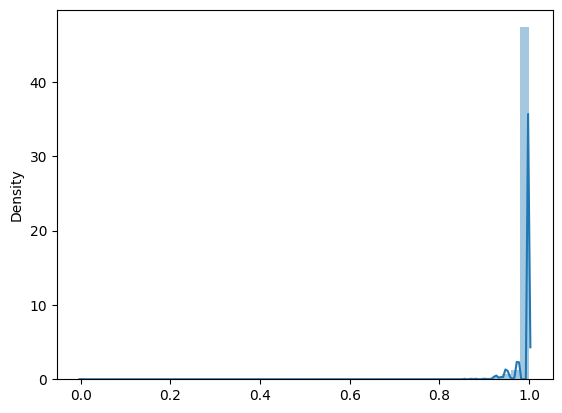

In [10]:
import seaborn as sns
sns.distplot(diss_matrix.flatten())

**Cluster Community Matrix and Mean Dissimilarity in Clusters**

In [11]:
clust_labels_1hot = np.eye(np.max(clustering.labels_) + 1)[clustering.labels_]
clust_same_comm = np.dot(clust_labels_1hot,np.transpose(clust_labels_1hot))

In [12]:
print(np.mean(diss_matrix*clust_same_comm))
print(np.mean(diss_matrix*(1-clust_same_comm)))

0.9550443473301268
0.042103269221803304


**Multi-dimensional Scaling (MDS)**

In [13]:
embedding = MDS(n_components=3,dissimilarity="precomputed",n_jobs=2,n_init=4)
features_transformed = embedding.fit_transform(diss_matrix)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [14]:
features_transformed

array([[ 0.28822935, -0.15581739,  0.60689053],
       [ 0.465456  ,  0.00772795,  0.4488997 ],
       [ 0.14772248,  0.27685497,  0.51699723],
       ...,
       [ 0.31878035, -0.13809681,  0.56310373],
       [-0.33177421,  0.52082949, -0.30739419],
       [-0.63091883, -0.21791926,  0.1740084 ]])

<Axes: >

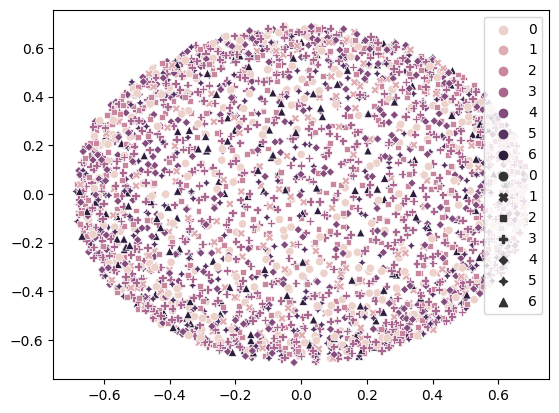

In [15]:
import seaborn as sns
sns.scatterplot(x=features_transformed[:,0],y=features_transformed[:,1],style=labels,hue=labels)

# Implementation of Line Graph Neural Network (LGNN)

In [56]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.nn.pytorch.conv import GraphConv as GCNconv

import numpy as np
import scipy.sparse as ss


class LGNNModule(nn.Module):
    """This is a graph network block of LGNN"""

    def __init__(self, in_feats, out_feats, radius, batchnorm):
        super().__init__()
        self.out_feats = out_feats
        self.radius = radius

        new_linear = lambda: nn.Linear(in_feats, out_feats)
        new_linear_list = lambda: nn.ModuleList([new_linear() for i in range(radius)])

        self.theta_x, self.theta_deg, self.theta_y = new_linear(), new_linear(), new_linear()
        self.theta_list = new_linear_list()

        self.gamma_y, self.gamma_deg, self.gamma_x = new_linear(), new_linear(), new_linear()
        self.gamma_list = new_linear_list()

        self.batchnorm = batchnorm
        self.bn_x = nn.BatchNorm1d(out_feats)
        self.bn_y = nn.BatchNorm1d(out_feats)

    def aggregate(self, a_graph, z):
        z_list = []
        a_graph.ndata['z'] = z
        a_graph.update_all(fn.copy_u(u="z", out="m"), fn.sum(msg="m", out="z"))
        z_list.append(a_graph.ndata["z"])
        for i in range(self.radius - 1):
            for j in range(2 ** i):
                a_graph.update_all(fn.copy_u(u="z", out="m"), fn.sum(msg="m", out="z"))
            z_list.append(a_graph.ndata["z"])
        return z_list

    def forward(self, g, lg, x, y, deg_g, deg_lg, pm_pd, last=False):
        pmpd_x = F.embedding(pm_pd, x)

        sum_x = sum(theta(z) for theta, z in zip(self.theta_list, self.aggregate(g, x)))

        g.edata['y'] = y
        g.update_all(fn.copy_e("y", "m"), fn.sum("m", "pmpd_y"))
        pmpd_y = g.ndata.pop("pmpd_y")

        x = self.theta_x(x) + self.theta_deg(deg_g * x) + sum_x + self.theta_y(pmpd_y)
        n = self.out_feats // 2
        x = th.cat([x[:, :n], F.relu(x[:, n:])], 1)
        if self.batchnorm:
            x = self.bn_x(x)

        if last:
            return x  # do not compute the rest of the lgnn part to avoid memory leak

        sum_y = sum(gamma(z) for gamma, z in zip(self.gamma_list, self.aggregate(lg, y)))

        y = self.gamma_y(y) + self.gamma_deg(deg_lg * y) + sum_y + self.gamma_x(pmpd_x)
        y = th.cat([y[:, :n], F.relu(y[:, n:])], 1)
        if self.batchnorm:
            y = self.bn_y(y)

        return x, y


class LGNN_Net(nn.Module):
    """This is a whole LGNN"""

    def __init__(
        self, g, in_feats, hidden_size, hidden_layers, out_feats, dropout, batchnorm, lg, radius
    ):
        super(LGNN_Net, self).__init__()
        self.g = g
        self.lg = lg
        in_feats = [in_feats] + [hidden_size] * hidden_layers
        self.module_list = nn.ModuleList(
            [LGNNModule(m, n, radius, batchnorm) for m, n in zip(in_feats[:-1], in_feats[1:])]
        )
        self.linear = nn.Linear(in_feats[-1], out_feats)
        self.dropout = nn.Dropout(dropout)

        self.pmpd = self.g.edges()[0]

        # compute the degrees
        self.deg_g = self.g.in_degrees().float().unsqueeze(1)
        self.deg_lg = self.lg.in_degrees().float().unsqueeze(1)

    def forward(self, features):
        (h, lg_h) = features
        for i, module in enumerate(self.module_list):
            if i == len(self.module_list) - 1:
                h = module(
                    self.g, self.lg, h, lg_h, self.deg_g, self.deg_lg, self.pmpd, last=True
                )  # the last pass should only return h, otherwhise we get a memory leak
                h = self.dropout(h)
            else:
                h, lg_h = module(self.g, self.lg, h, lg_h, self.deg_g, self.deg_lg, self.pmpd)
                h = self.dropout(h)
                lg_h = self.dropout(lg_h)
        h = self.linear(h)
        h = F.log_softmax(h, 1)
        return h

In [57]:
# dgl
import dgl
import dgl.function as fn
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh

# pytorch
import torch as th
import torch.nn as nn
import torch.nn.functional as F

# other
import time
import numpy as np
import random as rng
import scipy.sparse as ss
import networkx as nx
import pickle

from sklearn.metrics import accuracy_score as acc

**Data Loading**

In [58]:
#Loading CORA
data = citegrh.load_cora()
g = data[0]
features = th.FloatTensor(g.ndata['feat'].numpy())
labels = th.LongTensor(g.ndata['label'].numpy())
mask = th.BoolTensor(g.ndata['train_mask'])
src, dst = g.edges()
lg_feat = np.vstack([features[s, :] * features[d, :] for s, d in zip(src, dst)])

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [59]:
lg = g.line_graph(backtracking=False)

**Select Training Set**

In [60]:
percentage_train = 0.1
percentage_val = 0.1

with open("/kaggle/input/permutations/cora_permutation1.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(g.number_of_nodes())
mask_val = np.zeros(g.number_of_nodes())

i_train = int(percentage_train*g.number_of_nodes())
i_val = i_train + int(percentage_val*g.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

**Training**

In [61]:
import itertools

class perm_inv_loss:
    def __init__(self, labels):
        self.labels = labels
        self.num_classes = len(labels.unique())
        self.label_perms = {i: None for i in range(2, self.num_classes + 1)}

    def compute_loss(self, logits, mask):
        if self.label_perms[self.num_classes] is None:
            self.label_perms[self.num_classes] = list(
                itertools.permutations(range(self.num_classes))
            )

        loss = th.tensor(np.infty, requires_grad=True)
        for p in self.label_perms:
            loss = th.min(loss, F.nll_loss(logits[mask][:, p], self.labels[mask]))
        return loss

    def approximate_loss(self, logits, mask, nclasses=3):
        if self.label_perms[nclasses] is None:
            self.label_perms[nclasses] = list(itertools.permutations(range(nclasses)))

        # randomly assign labels to new clusters (trying to roughly achieve equal distribution)
        assignments = np.random.choice(
            [i % nclasses for i in range(self.num_classes)], size=self.num_classes, replace=False
        )
        new_labels = th.LongTensor(assignments[self.labels])
        one_hot_assignments = th.BoolTensor(np.eye(np.max(assignments) + 1)[assignments])
        tensors = [th.sum(logits[:, one_hot_assignments[:, i]], dim=1) for i in range(nclasses)]
        new_logits = th.stack(tensors, 1)
        new_label_perms = list(itertools.permutations(np.unique(new_labels)))
        loss = th.tensor(np.infty, requires_grad=True)
        for p in new_label_perms:
            loss = th.min(loss, F.nll_loss(new_logits[mask][:, p], new_labels[mask]))
        return loss


loss_function = perm_inv_loss(labels)

In [62]:
import time
import copy

# create the model
degrees = True
if degrees:
    # use degree as the input feature
    # compute the degrees
    g_feat = g.in_degrees().float().unsqueeze(1)
    lg_feat = lg.in_degrees().float().unsqueeze(1)  
else:
    # use astracts as input feature
    g_feat = th.FloatTensor(data.features)
    lg_feat = th.FloatTensor(np.vstack([data.features[e[0],:] for e in data.graph.edges]))
features = (g_feat,lg_feat)
    
net = LGNN_Net(g=g,in_feats=g_feat.shape[1],hidden_size=21,hidden_layers=2,out_feats=7,
               dropout=0.1,batchnorm=False,lg=lg,radius=2)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
current_best = 0 #arbitrarily high
current_best_epoch = 0
current_best_params = None
no_improvement_for = 0

for epoch in range(10000):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    prediction = net(features)
    train_rand=rand_score(labels[mask_train].numpy(),np.argmax(prediction[mask_train].detach().numpy(), axis=1))
    validation_rand=rand_score(labels[mask_val].numpy(),np.argmax(prediction[mask_val].detach().numpy(), axis=1))

    train_rand_ev.append(train_rand)
    val_rand_ev.append(validation_rand)
    
    if train_rand>current_best:
        current_best = train_rand
        current_best_epoch = epoch
        current_best_params = copy.deepcopy(net.state_dict())
        no_improvement_for = 0
    else: no_improvement_for += 1
    
    if no_improvement_for>100:
        break
    
    net.train()

    # Compute loss for train nodes
    logits = net(features)

    loss = loss_function.approximate_loss(logits,mask_train,nclasses=7)
    loss_ev.append(loss.detach().item())

    #loss = F.nll_loss(logits[mask_train], labels[mask_train])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")
        
net.load_state_dict(current_best_params)

Epoch 00000 | Loss 1705.8364 | Train.Rand 0.0038 | Valid.Rand 0.0118 | Time(s) unknown
Epoch 00001 | Loss 1591.4167 | Train.Rand 0.0614 | Valid.Rand 0.0219 | Time(s) unknown
Epoch 00002 | Loss 1638.4634 | Train.Rand -0.0069 | Valid.Rand -0.0037 | Time(s) unknown
Epoch 00003 | Loss 1252.2758 | Train.Rand 0.0382 | Valid.Rand 0.0178 | Time(s) 1.1824
Epoch 00004 | Loss 1603.4882 | Train.Rand 0.0483 | Valid.Rand 0.0181 | Time(s) 1.2255
Epoch 00005 | Loss 1380.4530 | Train.Rand 0.0140 | Valid.Rand 0.0026 | Time(s) 1.2881
Epoch 00006 | Loss 1136.4011 | Train.Rand 0.0159 | Valid.Rand 0.0005 | Time(s) 1.2793
Epoch 00007 | Loss 790.5477 | Train.Rand 0.0816 | Valid.Rand 0.0225 | Time(s) 1.2684
Epoch 00008 | Loss 1011.3798 | Train.Rand -0.0001 | Valid.Rand 0.0067 | Time(s) 1.2607
Epoch 00009 | Loss 1041.3112 | Train.Rand -0.0086 | Valid.Rand -0.0001 | Time(s) 1.2549
Epoch 00010 | Loss 794.0044 | Train.Rand 0.0029 | Valid.Rand 0.0131 | Time(s) 1.2535
Epoch 00011 | Loss 675.1579 | Train.Rand 0.0407 

<All keys matched successfully>

In [63]:
net.load_state_dict(current_best_params)

<All keys matched successfully>

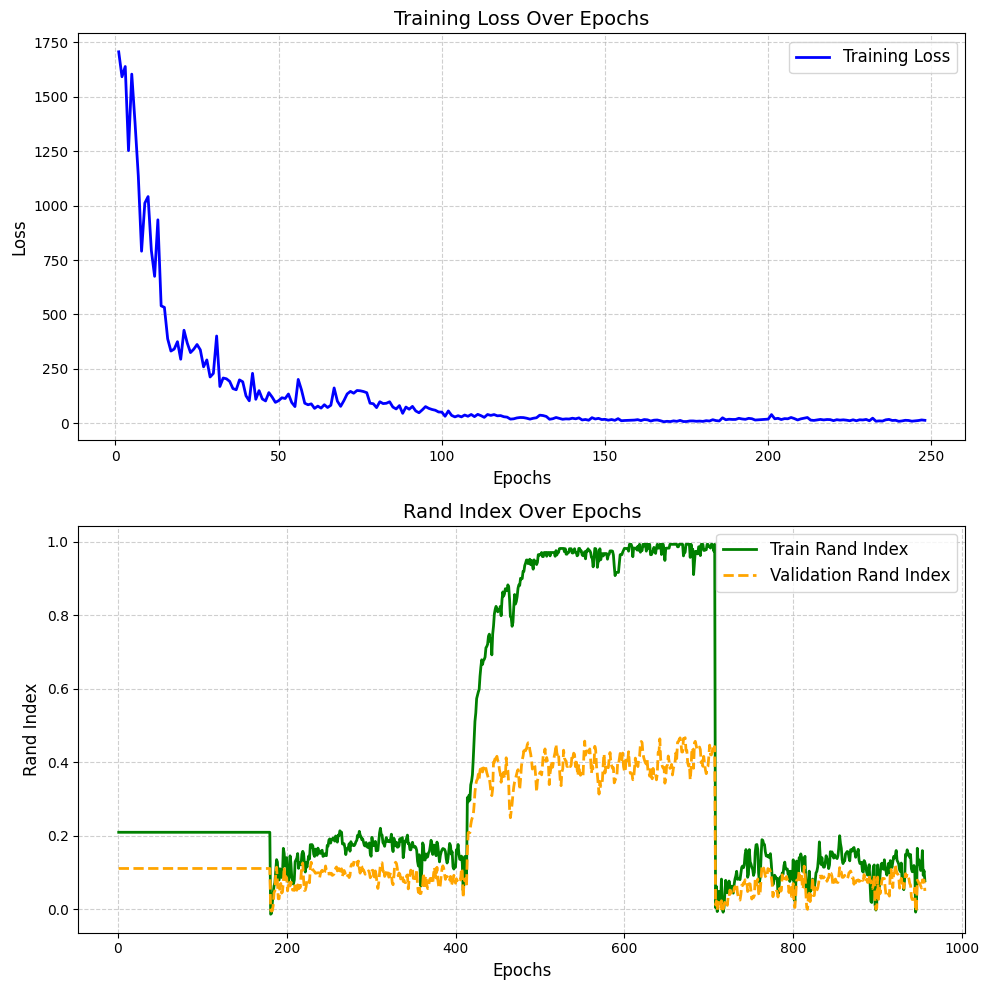

In [64]:
import matplotlib.pyplot as plt

# Ensure consistent lengths for epochs and recorded metrics
epochs_loss = range(1, len(loss_ev) + 1)  # Length matches loss_ev
epochs_rand = range(1, len(train_rand_ev) + 1)  # Length matches train_rand_ev and val_rand_ev

# Create subplots for loss and Rand index visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Training Loss
axs[0].plot(epochs_loss, loss_ev, label='Training Loss', color='blue', linewidth=2)
axs[0].set_title('Training Loss Over Epochs', fontsize=14)
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend(fontsize=12)

# Rand Indices (Train vs Validation)
axs[1].plot(epochs_rand, train_rand_ev, label='Train Rand Index', color='green', linewidth=2)
axs[1].plot(epochs_rand, val_rand_ev, label='Validation Rand Index', color='orange', linestyle='--', linewidth=2)
axs[1].set_title('Rand Index Over Epochs', fontsize=14)
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('Rand Index', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend(fontsize=12)

# Display plots
plt.tight_layout()
plt.show()

In [65]:
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       dissims: 160.0 MiB
                   diss_matrix: 55.9 MiB
                     same_comm: 55.9 MiB
               clust_same_comm: 55.9 MiB
                   labels_1hot: 148.2 KiB
             clust_labels_1hot: 148.2 KiB
                node_positions: 42.4 KiB
                 train_rand_ev:  7.6 KiB
                   val_rand_ev:  7.6 KiB
           current_best_params:  5.2 KiB


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


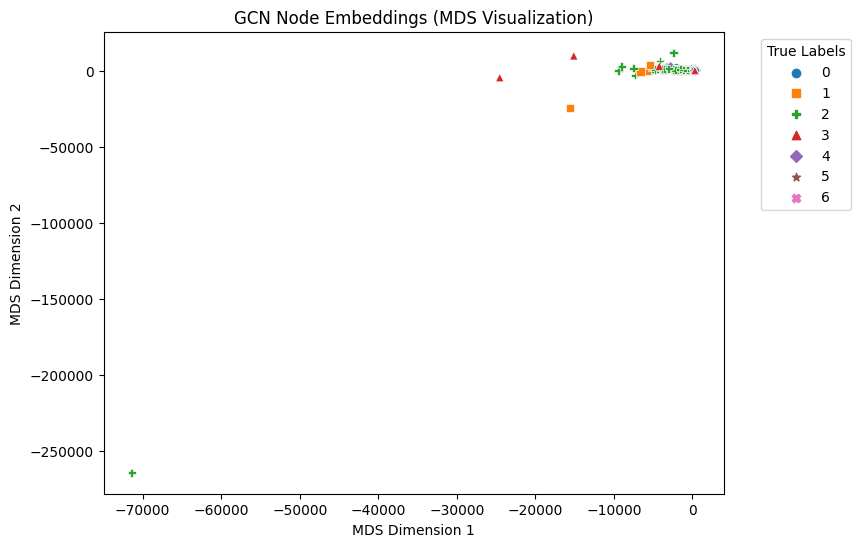

In [66]:
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract LGNN embeddings
net.eval()  # Set the model to evaluation mode
final_logits = net(features).detach().numpy()  # Extract node embeddings from LGNN

# Step 2: Compute Dissimilarity Matrix
# Here we use Euclidean distance between node embeddings
from scipy.spatial.distance import pdist, squareform
diss_matrix = squareform(pdist(final_logits, metric='euclidean'))  # Pairwise distances

# Step 3: Apply MDS for Dimensionality Reduction
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
node_positions = embedding.fit_transform(diss_matrix)

# Step 4: Set consistent color and shape mappings (optional, for alignment with LGNN)
unique_labels = np.unique(labels)
palette = sns.color_palette("tab10", len(unique_labels))
style_dict = {label: marker for label, marker in zip(unique_labels, ['o', 's', 'P', '^', 'D', '*', 'X'])}

# Step 5: Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=node_positions[:, 0],
    y=node_positions[:, 1],
    hue=labels,  # Use true labels for coloring
    style=labels,  # Use true labels for marker shapes
    palette=palette,  # Consistent colors with LGNN
    markers=style_dict,  # Consistent shapes with LGNN
    legend="full"
)
plt.title("GCN Node Embeddings (MDS Visualization)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**t-SNE Visualization**

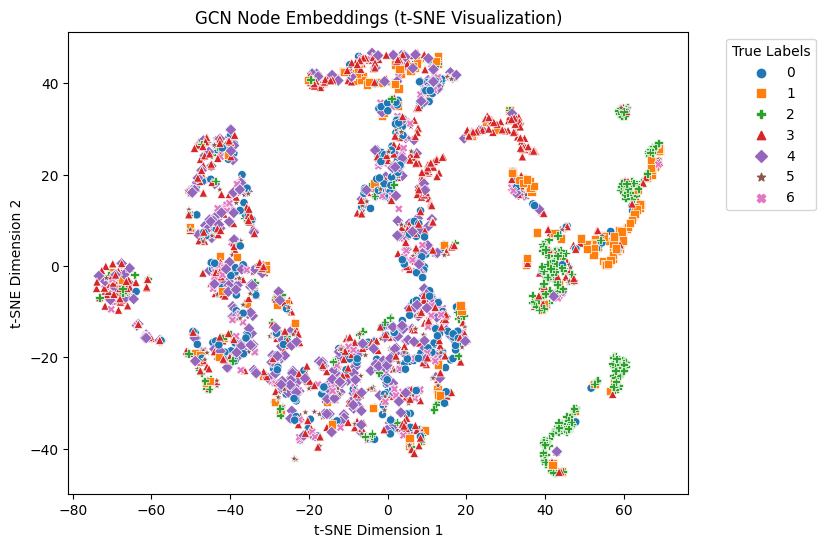

In [68]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
node_positions_tsne = tsne.fit_transform(final_logits)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=node_positions_tsne[:, 0],
    y=node_positions_tsne[:, 1],
    hue=labels,
    style=labels,
    palette=palette,
    markers=style_dict,
    legend="full"
)
plt.title("GCN Node Embeddings (t-SNE Visualization)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Embedding Distance Distribution**

/tmp/ipykernel_23/951512904.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_distances, label="Same Cluster", shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/951512904.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_distances, label="Different Cluster", shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.opt

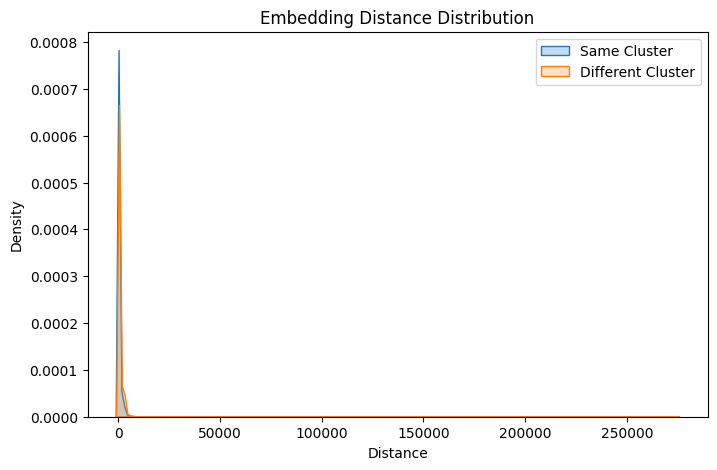

In [70]:
from scipy.spatial.distance import pdist, squareform

# Compute pairwise distances
distances = squareform(pdist(final_logits, metric='euclidean'))

# Mask distances for same-cluster vs. different-cluster comparisons
same_cluster = (labels[:, None] == labels[None, :])
different_cluster = ~same_cluster

# Extract distances
same_distances = distances[same_cluster]
diff_distances = distances[different_cluster]

# Plot distributions
plt.figure(figsize=(8, 5))
sns.kdeplot(same_distances, label="Same Cluster", shade=True)
sns.kdeplot(diff_distances, label="Different Cluster", shade=True)
plt.title("Embedding Distance Distribution")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.legend()
plt.show()


**Confusion Matrix**

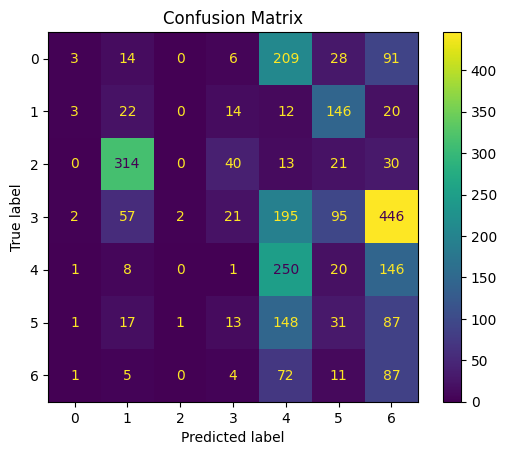

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute predictions
preds = np.argmax(final_logits, axis=1)

# Confusion matrix
cm = confusion_matrix(labels.numpy(), preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))
disp.plot(cmap="viridis", values_format="d")
plt.title("Confusion Matrix")
plt.show()

**Cluster Size Distribution**

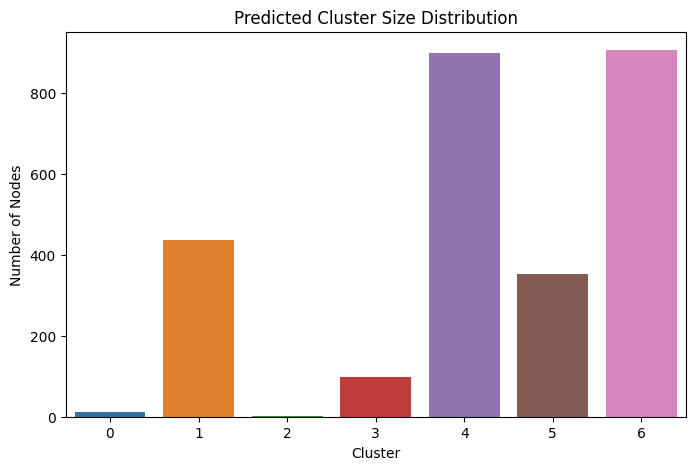

In [72]:
unique, counts = np.unique(preds, return_counts=True)

# Plot cluster sizes
plt.figure(figsize=(8, 5))
sns.barplot(x=unique, y=counts)
plt.title("Predicted Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Nodes")
plt.show()


In [75]:
from sklearn import metrics as skmetrics
from scipy import sparse as sp
from math import log
import pandas as pd


def mutual_info_score(labels, preds):
    return skmetrics.adjusted_mutual_info_score(labels, preds, average_method="arithmetic")


def variation_of_information_score(labels, preds):
    def mi(x, y):
        contingency = skmetrics.cluster.contingency_matrix(x, y, sparse=True)

        nzx, nzy, nz_val = sp.find(contingency)
        contingency_sum = contingency.sum()

        pi = np.ravel(contingency.sum(axis=1))
        pj = np.ravel(contingency.sum(axis=0))

        log_contingency_nm = np.log(nz_val)

        contingency_nm = nz_val / contingency_sum


        # Don't need to calculate the full outer product, just for non-zeroes
        outer = pi.take(nzx).astype(np.int64, copy=False) * pj.take(nzy).astype(
            np.int64, copy=False
        )

        log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())

        mi = (
            contingency_nm * (log_contingency_nm - log(contingency_sum))
            + contingency_nm * log_outer
        )

        return mi.sum()

    return mi(labels, labels) + mi(preds, preds) - 2 * mi(labels, preds)


def compute_performance(labels, logits, splits):
    logits = logits.detach().numpy()
    preds = np.argmax(logits, axis=1)
    labels = labels.numpy()

    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    pred_sets = {
        "All ": preds,
        "Train": preds[train_mask],
        "Val": preds[val_mask],
        "Test": preds[test_mask],
    }
    label_sets = {
        "All ": labels,
        "Train": labels[train_mask],
        "Val": labels[val_mask],
        "Test": labels[test_mask],
    }
    eval_functions = {
        "Rand-Index": rand_score,
        "Mutual Information": mutual_info_score,
        "Variation of Information": variation_of_information_score,
    }
    scores = {
        subset: {
            name: func(label_sets[subset], pred_sets[subset])
            for name, func in eval_functions.items()
        }
        for subset in pred_sets.keys()
    }
    return scores


def performance_as_df(labels, logits, splits):
    scores = compute_performance(labels, logits, splits)
    return pd.DataFrame(scores)


net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
performance_as_df(labels,final_prediction,mask)

,All,Train,Val,Test
Rand-Index,0.157543,0.140931,0.155776,0.160580
Mutual Information,0.205772,0.200121,0.215194,0.212231
Variation of Information,2.589432,2.545464,2.499228,2.535694


# Implementation of Graph Convolutional Network (Kipf and Welling)

In [96]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import numpy as np


class LinearModule(nn.Module):
    """Linear transformation part of the GCN layer"""

    def __init__(self, in_feats, out_feats, activation):
        super(LinearModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = node.data["h"]
        h = self.linear(h)
        h = self.activation(h)
        return {"h": h}


class GCN(nn.Module):
    """This is a graph network block of GCN"""

    def __init__(self, in_feats, out_feats, activation, batchnorm=False):
        super(GCN, self).__init__()
        self.apply_mod = LinearModule(in_feats, out_feats, activation)
        self.batchnorm = batchnorm
        self.bn = nn.BatchNorm1d(out_feats)

    def forward(self, g, feature):
        g.ndata["h"] = feature
        g.update_all(
            message_func=fn.copy_u(u="h", out="m"), reduce_func=fn.sum(msg="m", out="h")
        )
        g.apply_nodes(func=self.apply_mod)

        res = g.ndata.pop("h")
        if self.batchnorm:
            res = self.bn(res)
        return res


class GCN_Net(nn.Module):
    """This is a whole GCN"""

    def __init__(self, g, in_feats, hidden_size, hidden_layers, out_feats, dropout, batchnorm):
        super(GCN_Net, self).__init__()
        self.g = g
        self.gcn_in = GCN(in_feats, hidden_size, F.relu, batchnorm)
        self.gcn_hidden = [
            GCN(hidden_size, hidden_size, F.relu, batchnorm) for i in range(hidden_layers)
        ]
        self.dropout = nn.Dropout(dropout)
        self.gcn_out = GCN(hidden_size, out_feats, F.relu, batchnorm)

    def forward(self, features):
        h = self.gcn_in(self.g, features)
        for layer in self.gcn_hidden:
            h = self.dropout(h)
            h = layer(self.g, h)
        h = self.dropout(h)
        h = self.gcn_out(self.g, h)
        h = F.log_softmax(h, 1)
        return h

In [97]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import pickle
import copy
import numpy as np

import itertools

**Data Loading**

In [98]:
from dgl.data import citation_graph as citegrh
import networkx as nx

data = citegrh.load_cora()
g = data[0]
features = th.FloatTensor(g.ndata['feat'])
labels = th.LongTensor(g.ndata['label'])
mask = th.BoolTensor(g.ndata['train_mask'])

g = dgl.remove_self_loop(g)
g = dgl.add_self_loop(g)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


**Select Training, Validation and Test Set**

In [99]:
percentage_train = 0.1
percentage_val = 0.1

with open("/kaggle/input/permutations/cora_permutation1.pickle","rb") as f:
    perm1 = pickle.load(f)
mask_train = np.zeros(g.number_of_nodes())
mask_val = np.zeros(g.number_of_nodes())

i_train = int(percentage_train*g.number_of_nodes())
i_val = i_train + int(percentage_val*g.number_of_nodes())
mask_train[perm1[range(0,i_train)]] = 1
mask_val[perm1[range(i_train,i_val)]] = 1
mask_train = th.BoolTensor(mask_train)
mask_val = th.BoolTensor(mask_val)

In [100]:
features.shape

torch.Size([2708, 1433])

**Training**

In [101]:
class perm_inv_loss:
    def __init__(self, labels):
        self.labels = labels
        self.num_classes = len(labels.unique())
        self.label_perms = {i: None for i in range(2, self.num_classes + 1)}

    def compute_loss(self, logits, mask):
        if self.label_perms[self.num_classes] is None:
            self.label_perms[self.num_classes] = list(
                itertools.permutations(range(self.num_classes))
            )

        loss = th.tensor(np.infty, requires_grad=True)
        for p in self.label_perms:
            loss = th.min(loss, F.nll_loss(logits[mask][:, p], self.labels[mask]))
        return loss

    def approximate_loss(self, logits, mask, nclasses=3):
        if self.label_perms[nclasses] is None:
            self.label_perms[nclasses] = list(itertools.permutations(range(nclasses)))

        # randomly assign labels to new clusters (trying to roughly achieve equal distribution)
        assignments = np.random.choice(
            [i % nclasses for i in range(self.num_classes)], size=self.num_classes, replace=False
        )
        new_labels = th.LongTensor(assignments[self.labels])
        one_hot_assignments = th.BoolTensor(np.eye(np.max(assignments) + 1)[assignments])
        tensors = [th.sum(logits[:, one_hot_assignments[:, i]], dim=1) for i in range(nclasses)]
        new_logits = th.stack(tensors, 1)
        new_label_perms = list(itertools.permutations(np.unique(new_labels)))
        loss = th.tensor(np.infty, requires_grad=True)
        for p in new_label_perms:
            loss = th.min(loss, F.nll_loss(new_logits[mask][:, p], new_labels[mask]))
        return loss

In [102]:
loss_function = perm_inv_loss(labels)

In [103]:
from sklearn import metrics as skmetrics

def rand_score(labels, preds):
    return skmetrics.adjusted_rand_score(labels, preds)

In [104]:
import time

net = GCN_Net(g=g, in_feats=features.shape[1], hidden_size=150, hidden_layers=1, out_feats=len(np.unique(labels)),
              dropout=0.4, batchnorm=True)
#print(net)

optimizer = th.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
net.train() # Set to training mode (use dropout)

dur = []
loss_ev = []
current_best = 0 #arbitrarily high
current_best_epoch = 0
current_best_params = None
no_improvement_for = 0

for epoch in range(10000):
    if epoch >=3:
        t0 = time.time()

    # Compute loss for test nodes (only for validation, not used by optimizer)
    net.eval()
    prediction = net(features)
    train_rand=rand_score(labels[mask_train].numpy(),np.argmax(prediction[mask_train].detach().numpy(), axis=1))
    validation_rand=rand_score(labels[mask_val].numpy(),np.argmax(prediction[mask_val].detach().numpy(), axis=1))

    train_rand_ev.append(train_rand)
    val_rand_ev.append(validation_rand)
    
    if train_rand>current_best:
        current_best = train_rand
        current_best_epoch = epoch
        current_best_params = copy.deepcopy(net.state_dict())
        no_improvement_for = 0
    else: no_improvement_for += 1
    
    if no_improvement_for>100:
        break

    net.train()

    # Compute loss for train nodes
    logits = net(features)

    #loss = loss_function.approximate_loss(logits,mask_train,nclasses=7)
    loss = F.nll_loss(logits[mask_train], labels[mask_train])
    loss_ev.append(loss.detach().item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) {np.mean(dur):.4f}")
    else:
        print(f"Epoch {epoch:05d} | Loss {loss.item():.4f} | Train.Rand {train_rand:.4f} | Valid.Rand {validation_rand:.4f} | Time(s) unknown")
        
net.load_state_dict(current_best_params)

Epoch 00000 | Loss 2.0751 | Train.Rand 0.0776 | Valid.Rand 0.0442 | Time(s) unknown
Epoch 00001 | Loss 1.4169 | Train.Rand 0.1786 | Valid.Rand 0.1122 | Time(s) unknown
Epoch 00002 | Loss 1.2704 | Train.Rand 0.3937 | Valid.Rand 0.1851 | Time(s) unknown
Epoch 00003 | Loss 1.1697 | Train.Rand 0.4292 | Valid.Rand 0.2369 | Time(s) 0.0531
Epoch 00004 | Loss 1.1009 | Train.Rand 0.4229 | Valid.Rand 0.2489 | Time(s) 0.0537
Epoch 00005 | Loss 1.0019 | Train.Rand 0.5383 | Valid.Rand 0.2774 | Time(s) 0.0529
Epoch 00006 | Loss 0.9490 | Train.Rand 0.4766 | Valid.Rand 0.2525 | Time(s) 0.0521
Epoch 00007 | Loss 0.9084 | Train.Rand 0.5173 | Valid.Rand 0.2820 | Time(s) 0.0517
Epoch 00008 | Loss 0.8910 | Train.Rand 0.5072 | Valid.Rand 0.3208 | Time(s) 0.0515
Epoch 00009 | Loss 0.8533 | Train.Rand 0.5596 | Valid.Rand 0.3549 | Time(s) 0.0516
Epoch 00010 | Loss 0.7965 | Train.Rand 0.5722 | Valid.Rand 0.3625 | Time(s) 0.0517
Epoch 00011 | Loss 0.8317 | Train.Rand 0.5716 | Valid.Rand 0.3295 | Time(s) 0.0514
E

<All keys matched successfully>

In [106]:
net.load_state_dict(current_best_params)

<All keys matched successfully>

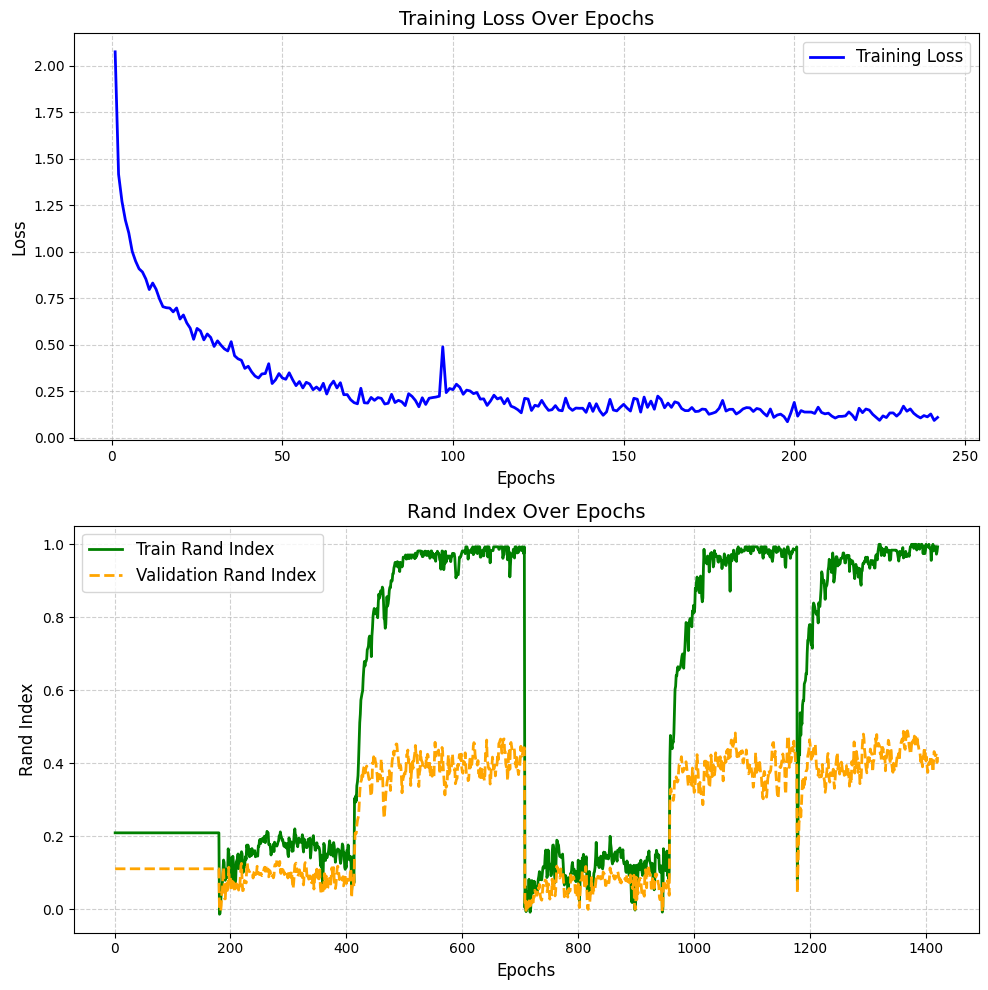

In [107]:
import matplotlib.pyplot as plt

# Ensure consistent lengths for plotting
epochs_loss = range(1, len(loss_ev) + 1)  # Matches loss_ev length
epochs_rand = range(1, len(train_rand_ev) + 1)  # Matches train_rand_ev and val_rand_ev length

# Create subplots for loss and Rand Index visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Training Loss
axs[0].plot(epochs_loss, loss_ev, label='Training Loss', color='blue', linewidth=2)
axs[0].set_title('Training Loss Over Epochs', fontsize=14)
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend(fontsize=12)

# Rand Indices (Train vs Validation)
axs[1].plot(epochs_rand, train_rand_ev, label='Train Rand Index', color='green', linewidth=2)
axs[1].plot(epochs_rand, val_rand_ev, label='Validation Rand Index', color='orange', linestyle='--', linewidth=2)
axs[1].set_title('Rand Index Over Epochs', fontsize=14)
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('Rand Index', fontsize=12)
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].legend(fontsize=12)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


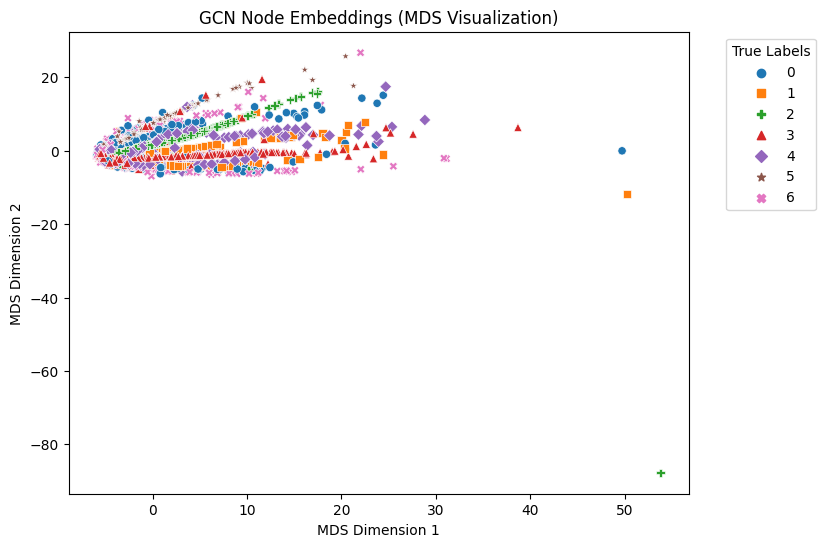

In [108]:
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract GCN embeddings
net.eval()
final_logits_gcn = net(features).detach().numpy()  # Get logits from the trained GCN model

# Step 2: Compute Dissimilarity Matrix (using Euclidean distance)
from scipy.spatial.distance import pdist, squareform
diss_matrix = squareform(pdist(final_logits_gcn, metric='euclidean'))

# Step 3: Apply MDS for Dimensionality Reduction
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
node_positions = embedding.fit_transform(diss_matrix)

# Step 4: Set consistent color and shape mappings (optional, for alignment with LGNN)
unique_labels = np.unique(labels)
palette = sns.color_palette("tab10", len(unique_labels))
style_dict = {label: marker for label, marker in zip(unique_labels, ['o', 's', 'P', '^', 'D', '*', 'X'])}

# Step 5: Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=node_positions[:, 0],
    y=node_positions[:, 1],
    hue=labels,  # Use true labels for coloring
    style=labels,  # Use true labels for marker shapes
    palette=palette,  # Consistent colors with LGNN
    markers=style_dict,  # Consistent shapes with LGNN
    legend="full"
)
plt.title("GCN Node Embeddings (MDS Visualization)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**t-SNE Visualization**

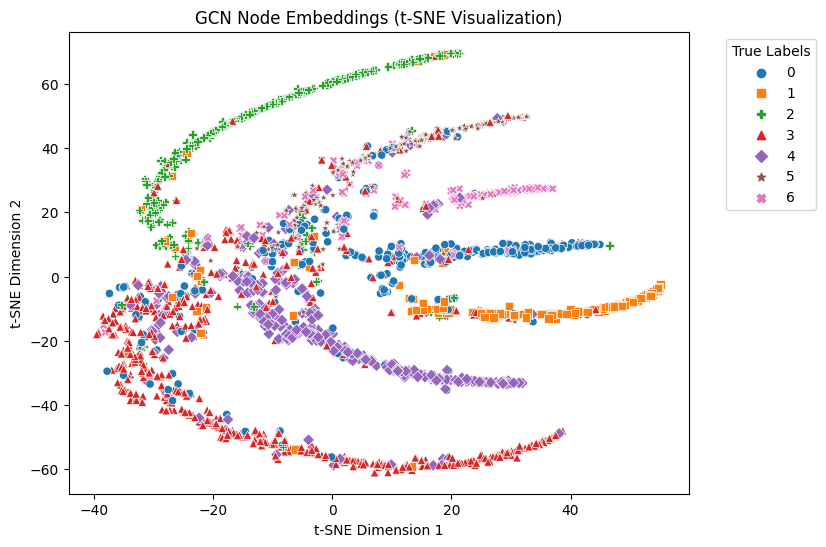

In [109]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
node_positions_tsne = tsne.fit_transform(final_logits_gcn)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=node_positions_tsne[:, 0],
    y=node_positions_tsne[:, 1],
    hue=labels,
    style=labels,
    palette=palette,
    markers=style_dict,
    legend="full"
)
plt.title("GCN Node Embeddings (t-SNE Visualization)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="True Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Embedding Distance Distribution**

/tmp/ipykernel_23/4128699349.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_distances, label="Same Cluster", shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_23/4128699349.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_distances, label="Different Cluster", shade=True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.o

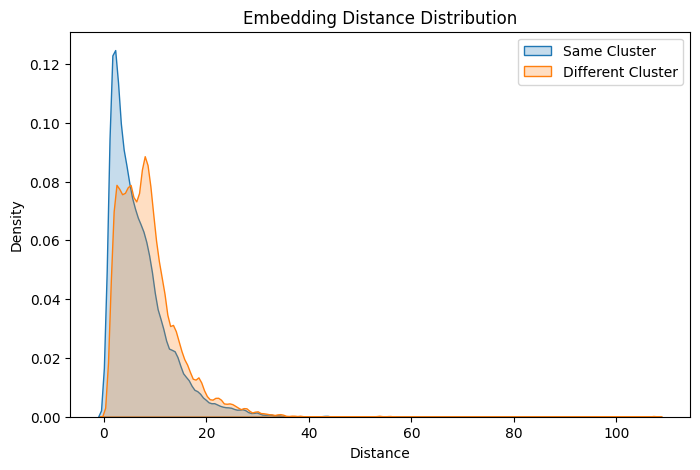

In [110]:
from scipy.spatial.distance import pdist, squareform

# Compute pairwise distances
distances = squareform(pdist(final_logits_gcn, metric='euclidean'))

# Mask distances for same-cluster vs. different-cluster comparisons
same_cluster = (labels[:, None] == labels[None, :])
different_cluster = ~same_cluster

# Extract distances
same_distances = distances[same_cluster]
diff_distances = distances[different_cluster]

# Plot distributions
plt.figure(figsize=(8, 5))
sns.kdeplot(same_distances, label="Same Cluster", shade=True)
sns.kdeplot(diff_distances, label="Different Cluster", shade=True)
plt.title("Embedding Distance Distribution")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.legend()
plt.show()

**Confusion Matrix**

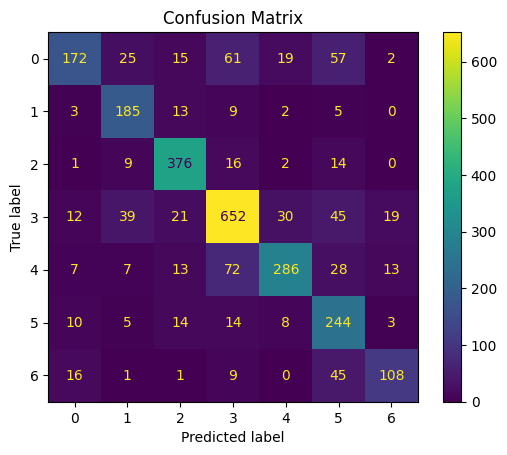

In [111]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute predictions
preds = np.argmax(final_logits_gcn, axis=1)

# Confusion matrix
cm = confusion_matrix(labels.numpy(), preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))
disp.plot(cmap="viridis", values_format="d")
plt.title("Confusion Matrix")
plt.show()

**Cluster Size Distribution**

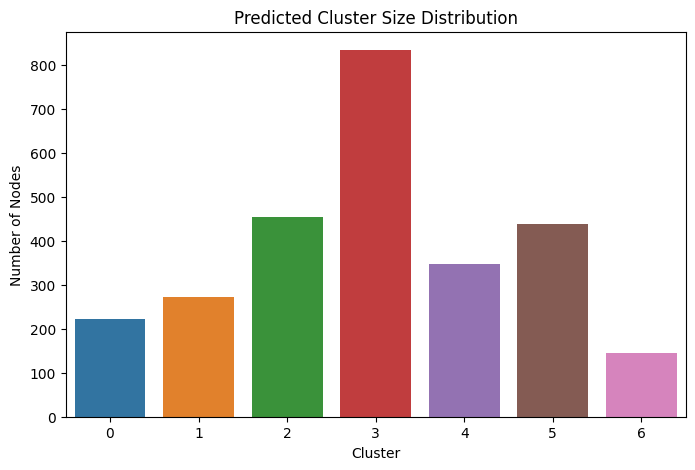

In [112]:
unique, counts = np.unique(preds, return_counts=True)

# Plot cluster sizes
plt.figure(figsize=(8, 5))
sns.barplot(x=unique, y=counts)
plt.title("Predicted Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Nodes")
plt.show()

**Evaluation**

In [94]:
from sklearn import metrics as skmetrics
from scipy import sparse as sp
from math import log
import pandas as pd


def mutual_info_score(labels, preds):
    return skmetrics.adjusted_mutual_info_score(labels, preds, average_method="arithmetic")


def variation_of_information_score(labels, preds):
    def mi(x, y):
        contingency = skmetrics.cluster.contingency_matrix(x, y, sparse=True)

        nzx, nzy, nz_val = sp.find(contingency)
        contingency_sum = contingency.sum()

        pi = np.ravel(contingency.sum(axis=1))
        pj = np.ravel(contingency.sum(axis=0))

        log_contingency_nm = np.log(nz_val)

        contingency_nm = nz_val / contingency_sum


        # Don't need to calculate the full outer product, just for non-zeroes
        outer = pi.take(nzx).astype(np.int64, copy=False) * pj.take(nzy).astype(
            np.int64, copy=False
        )

        log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())

        mi = (
            contingency_nm * (log_contingency_nm - log(contingency_sum))
            + contingency_nm * log_outer
        )

        return mi.sum()

    return mi(labels, labels) + mi(preds, preds) - 2 * mi(labels, preds)


def compute_performance(labels, logits, splits):
    logits = logits.detach().numpy()
    preds = np.argmax(logits, axis=1)
    labels = labels.numpy()

    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    pred_sets = {
        "All ": preds,
        "Train": preds[train_mask],
        "Val": preds[val_mask],
        "Test": preds[test_mask],
    }
    label_sets = {
        "All ": labels,
        "Train": labels[train_mask],
        "Val": labels[val_mask],
        "Test": labels[test_mask],
    }
    eval_functions = {
        "Rand-Index": rand_score,
        "Mutual Information": mutual_info_score,
        "Variation of Information": variation_of_information_score,
    }
    scores = {
        subset: {
            name: func(label_sets[subset], pred_sets[subset])
            for name, func in eval_functions.items()
        }
        for subset in pred_sets.keys()
    }
    return scores


def performance_as_df(labels, logits, splits):
    scores = compute_performance(labels, logits, splits)
    return pd.DataFrame(scores)


In [105]:
net.eval() # Set net to evaluation mode (deactivates dropout)
final_prediction = net(features).detach()
performance_as_df(labels,final_prediction,{"train":mask_train,"val":mask_val,"test":mask_val})

,All,Train,Val,Test
Rand-Index,0.515261,0.480737,0.502876,0.513702
Mutual Information,0.500880,0.534001,0.486984,0.502257
Variation of Information,1.811317,1.664497,1.812272,1.781693
